# Data preparation

In [1]:
import copy
import os
import numpy as np
import pickle
import deepof.data
from IPython import display
from networkx import Graph, draw
import deepof.visuals
import matplotlib.pyplot as plt
import seaborn as sns
from deepof.data_loading import get_dt, save_dt
from deepof.visuals_utils import _preprocess_time_bins
import psutil
import warnings
from typing import List, Tuple, Dict, Callable


In [2]:
# We load only a small sample project to speed up the following steps
my_deepof_project = deepof.data.load_project("./tutorial_files/sample_project")

In [3]:
# This code will generate a dataset using graph representations, as well a some auxiliary objects
preprocessed_object, shapes, adj_matrix, to_preprocess, global_scaler = my_deepof_project.get_graph_dataset(
    animal_id="B", # Comment out for multi-animal embeddings
    center="Center",
    align="Spine_1",
    window_size=25,
    window_step=1,
    test_videos=1,
    preprocess=True,
    scale="standard",
)
samples_max = None
bin_size = None
bin_index = None
precomputed_bins = None

Reshaping                     : 100%|██████████| 2/2 [00:00<00:00,  7.91table/s]


In [4]:
preprocessed_train, _= preprocessed_object
pt_shape=get_dt(preprocessed_train,list(preprocessed_train.keys())[0], only_metainfo=True)['shape']

#get available memory -10% as buffer
available_mem=psutil.virtual_memory().available*0.9
#calculate maximum number of rows that fit in memory based on table info 
N_rows_max=int(available_mem/((pt_shape[1]+11)*pt_shape[2]*8))
if samples_max is None:
    samples_max=N_rows_max
elif samples_max>N_rows_max:
    warning_message = (
    "\033[38;5;208m\n"
    "Warning! The selected number of samples may exceed your available memory."
    "\033[0m"
)
    warnings.warn(warning_message)

bin_info=_preprocess_time_bins(coordinates=my_deepof_project, bin_size=bin_size,bin_index=bin_index,precomputed_bins=precomputed_bins, tab_dict_for_binning=preprocessed_object[0], samples_max=samples_max)
bin_info_test=_preprocess_time_bins(coordinates=my_deepof_project, bin_size=bin_size,bin_index=bin_index,precomputed_bins=precomputed_bins, tab_dict_for_binning=preprocessed_object[1], samples_max=samples_max)
bin_info.update(bin_info_test)

# Tensorflow training loop (see below)

# Pytorch trainign loop

In [5]:
import os
import torch
import numpy as np
from deepof.clustering.models_new import VaDEPT

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import kl_divergence, Normal, Uniform
import math

'''
def setup_runtime(seed: int = 42, use_tf32: bool = True, cudnn_benchmark: bool = True):
    import torch, random, numpy as np, os
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = cudnn_benchmark
    if torch.cuda.is_available():
        torch.backends.cuda.matmul.allow_tf32 = use_tf32
        torch.backends.cudnn.allow_tf32 = use_tf32
'''


'''
def cluster_frequencies_regularizer(soft_counts: torch.Tensor) -> torch.Tensor:
    mean_freq = torch.mean(soft_counts, dim=0)
    n_components = soft_counts.shape[1]
    uniform_target = torch.ones(n_components, device=soft_counts.device) / n_components
    kld_loss = nn.KLDivLoss(reduction="batchmean")
    return kld_loss(torch.log(mean_freq + 1e-9), uniform_target)


def vade_extra_losses(z_for_downstream, z_cat, gmm_means, gmm_log_vars, prior):

    #p_z_c without prior
    std = torch.exp(0.5 * gmm_log_vars).unsqueeze(0)
    means = gmm_means.unsqueeze(0)
    log_p_z_c = Normal(means, std).log_prob(z_for_downstream.unsqueeze(1)).sum(-1)
    p_z_c = F.softmax(log_p_z_c, dim=-1)

    prior_loss = -(z_cat * torch.log(prior.unsqueeze(0) + 1e-9)).sum(dim=-1).mean()
    clustering_loss = -(z_cat * p_z_c).sum(dim=-1).mean()
    return prior_loss, clustering_loss



class VaDELoss(nn.Module):
    def __init__(
        self,
        n_components: int,
        latent_dim: int,
        reg_cat_clusters: float = 0.0,
        kl_weight: float = 1.0,
        prior_loss_weight: float = 1.0,
        clustering_loss_weight: float = 1.0,
        posterior_temperature: float = 1.0,  # optional: >1 flattens p(c|z)
    ):
        super().__init__()
        self.n_components = n_components
        self.latent_dim = latent_dim
        self.reg_cat_clusters_weight = reg_cat_clusters
        self.kl_weight = kl_weight
        self.prior_loss_weight = prior_loss_weight
        self.clustering_loss_weight = clustering_loss_weight
        self.posterior_temperature = posterior_temperature
        self.pretrain_mode = False

    def forward(self, model_outputs: tuple, x_original: torch.Tensor) -> dict:
        (
            reconstruction_dist,
            latent_z,              # z used to compute z_cat in the model
            categorical_probs,     # z_cat
            kmeans_loss,           # already weighted
            z_mean,
            z_log_var,             # TF-compatible "log-var-like"
            gmm_params,
        ) = model_outputs
        
        # 1) Reconstruction loss (stay in current dtype)
        device = x_original.device.type
        B, T, N, F_node = x_original.shape
        x_reshaped = x_original.view(B, T, N * F_node)
        reconstruction_loss = -reconstruction_dist.log_prob(x_reshaped).mean()

        # Defaults
        kl_div = reconstruction_loss.detach().new_zeros(())
        cat_cluster_loss = reconstruction_loss.detach().new_zeros(())
        prior_loss = reconstruction_loss.detach().new_zeros(())
        clustering_loss = reconstruction_loss.detach().new_zeros(())

        if not self.pretrain_mode:
            # 2) Batch-mean categorical regularizer
            if self.reg_cat_clusters_weight > 0 and categorical_probs is not None:
                cat_cluster_loss = self.reg_cat_clusters_weight * cluster_frequencies_regularizer(categorical_probs)

            # 3) KL(q(z|x) || p(z)) and TF-style latent losses in float32 for stability
            with torch.amp.autocast(device, enabled=False):
                # Cast everything to float32 on the right device
                z_mean32 = z_mean.float()
                z_log_var32 = z_log_var.float()
                latent32 = latent_z.float()  # match z used for z_cat
                gmm_means32 = gmm_params["means"].float()
                gmm_log_vars32 = gmm_params["log_vars"].float()
                prior32 = gmm_params["prior"].float()

                LOG_2PI = math.log(2.0 * math.pi)
                # E_q[log q(z|x)] = -0.5 * [ D*(1 + log(2π)) + sum(log σ^2) ]
                log_q_z_given_x = -0.5 * (
                    self.latent_dim * (1.0 + LOG_2PI) + torch.sum(z_log_var32, dim=-1)
                )  # (B,)

                # log p(z=μ) = logsumexp_c [ log π_c + log N(μ | μ_c, Σ_c) ]
                diff = z_mean32.unsqueeze(1) - gmm_means32.unsqueeze(0)    # (B, C, D)
                inv_vars = torch.exp(-gmm_log_vars32).unsqueeze(0)        # (1, C, D)
                log_det = torch.sum(gmm_log_vars32, dim=-1).unsqueeze(0)  # (1, C)
                log_p_z_given_c = -0.5 * (
                    self.latent_dim * LOG_2PI + log_det + torch.sum(diff * diff * inv_vars, dim=-1)
                )  # (B, C)
                log_p_z = torch.logsumexp(torch.log(prior32 + 1e-9).unsqueeze(0) + log_p_z_given_c, dim=-1)  # (B,)

                kl_div32 = (log_q_z_given_x - log_p_z).mean()

                # TF-like extra latent regularizers computed with the same z used to get z_cat
                std = torch.exp(0.5 * gmm_log_vars32).unsqueeze(0)         # (1, C, D)
                means = gmm_means32.unsqueeze(0)                            # (1, C, D)
                log_p_z_c = Normal(means, std).log_prob(latent32.unsqueeze(1)).sum(-1)  # (B, C)
                if self.posterior_temperature != 1.0:
                    log_p_z_c = log_p_z_c / self.posterior_temperature
                p_z_c = F.softmax(log_p_z_c, dim=-1)                       # (B, C)

                z_cat32 = categorical_probs.float()
                prior_loss32 = -(z_cat32 * torch.log(prior32.unsqueeze(0) + 1e-9)).sum(dim=-1).mean()
                clustering_loss32 = -(z_cat32 * p_z_c).sum(dim=-1).mean()

            # Cast back to the working dtype
            kl_div = kl_div32.to(reconstruction_loss.dtype)
            prior_loss = prior_loss32.to(reconstruction_loss.dtype)
            clustering_loss = clustering_loss32.to(reconstruction_loss.dtype)

        total_loss = reconstruction_loss
        if not self.pretrain_mode:
            total_loss = (
                reconstruction_loss
                + self.kl_weight * kl_div
                + cat_cluster_loss
                + self.prior_loss_weight * prior_loss
                + self.clustering_loss_weight * clustering_loss
                + kmeans_loss
            )

        # nan guards (just in case)
        for name, tens in [("total_loss", total_loss),
                           ("reconstruction_loss", reconstruction_loss),
                           ("kl_divergence", kl_div),
                           ("cat_cluster_loss", cat_cluster_loss),
                           ("prior_loss", prior_loss),
                           ("clustering_loss", clustering_loss)]:
            if torch.isnan(tens):
                # Replace NaN with zero to avoid poisoning the run
                locals()[name] = torch.zeros_like(tens)

        return {
            "total_loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_divergence": kl_div,
            "cat_cluster_loss": cat_cluster_loss,
            "prior_loss": prior_loss,
            "clustering_loss": clustering_loss,
            "kmeans_loss": kmeans_loss,
        }
'''

'\ndef cluster_frequencies_regularizer(soft_counts: torch.Tensor) -> torch.Tensor:\n    mean_freq = torch.mean(soft_counts, dim=0)\n    n_components = soft_counts.shape[1]\n    uniform_target = torch.ones(n_components, device=soft_counts.device) / n_components\n    kld_loss = nn.KLDivLoss(reduction="batchmean")\n    return kld_loss(torch.log(mean_freq + 1e-9), uniform_target)\n\n\ndef vade_extra_losses(z_for_downstream, z_cat, gmm_means, gmm_log_vars, prior):\n\n    #p_z_c without prior\n    std = torch.exp(0.5 * gmm_log_vars).unsqueeze(0)\n    means = gmm_means.unsqueeze(0)\n    log_p_z_c = Normal(means, std).log_prob(z_for_downstream.unsqueeze(1)).sum(-1)\n    p_z_c = F.softmax(log_p_z_c, dim=-1)\n\n    prior_loss = -(z_cat * torch.log(prior.unsqueeze(0) + 1e-9)).sum(dim=-1).mean()\n    clustering_loss = -(z_cat * p_z_c).sum(dim=-1).mean()\n    return prior_loss, clustering_loss\n\n\n\nclass VaDELoss(nn.Module):\n    def __init__(\n        self,\n        n_components: int,\n        l

In [7]:
def cluster_frequencies_regularizer(soft_counts: torch.Tensor) -> torch.Tensor:
    mean_freq = torch.mean(soft_counts, dim=0)
    n_components = soft_counts.shape[1]
    uniform_target = torch.ones(n_components, device=soft_counts.device) / n_components
    kld_loss = nn.KLDivLoss(reduction="batchmean")
    return kld_loss(torch.log(mean_freq + 1e-9), uniform_target)

class VaDELoss(nn.Module):
    """
    Calculates the total loss for the VaDE model:
    reconstruction + KL(q||p) + optional regularizers.
    """
    def __init__(
        self,
        n_components: int,
        latent_dim: int,
        reg_cat_clusters: float = 0.0,
        kl_weight: float = 1.0,
        prior_loss_weight: float = 1.0,
        clustering_loss_weight: float = 1.0,
    ):
        super().__init__()
        self.n_components = n_components
        self.latent_dim = latent_dim
        self.reg_cat_clusters_weight = reg_cat_clusters
        self.kl_weight = kl_weight
        self.prior_loss_weight = prior_loss_weight
        self.clustering_loss_weight = clustering_loss_weight
        self.pretrain_mode = False

    def _vade_extra_losses(
        self,
        z_mean: torch.Tensor,
        z_cat: torch.Tensor,
        gmm_means: torch.Tensor,
        gmm_log_vars: torch.Tensor,
        prior: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Implements TF-like extra latent losses:
        - prior_loss: encourages z_cat to match prior
        - clustering_loss: aligns z_cat with p(z|c) (without prior)
        """
        # p(z|c) without prior
        std = torch.exp(0.5 * gmm_log_vars).unsqueeze(0)   # (1, C, D)
        means = gmm_means.unsqueeze(0)                     # (1, C, D)
        log_p_z_c = Normal(means, std).log_prob(z_mean.unsqueeze(1)).sum(-1)  # (B, C)
        p_z_c = F.softmax(log_p_z_c, dim=-1)              # (B, C)

        prior_loss = -(z_cat * torch.log(prior.unsqueeze(0) + 1e-9)).sum(dim=-1).mean()
        clustering_loss = -(z_cat * p_z_c).sum(dim=-1).mean()
        return prior_loss, clustering_loss

    def forward(
        self,
        model_outputs: tuple,
        x_original: torch.Tensor
    ) -> dict:
        """
        Unpacks model outputs and computes all loss components.
        """
        (
            reconstruction_dist,
            _latent_z,
            categorical_probs,
            kmeans_loss,  # already weighted in the model
            z_mean,
            z_log_var,    # log variance of q(z|x), consistent with sampling
            gmm_params,
        ) = model_outputs
        
        # 1) Reconstruction loss
        B, T, N, F_node = x_original.shape
        x_reshaped = x_original.view(B, T, N * F_node)
        reconstruction_loss = -reconstruction_dist.log_prob(x_reshaped).mean()
        
        kl_div = torch.tensor(0.0, device=x_original.device)
        cat_cluster_loss = torch.tensor(0.0, device=x_original.device)
        prior_loss = torch.tensor(0.0, device=x_original.device)
        clustering_loss = torch.tensor(0.0, device=x_original.device)

        if not self.pretrain_mode:
            # 2) Cluster frequency regularizer (mean z_cat vs uniform)
            if self.reg_cat_clusters_weight > 0 and categorical_probs is not None:
                cat_cluster_loss = self.reg_cat_clusters_weight * cluster_frequencies_regularizer(categorical_probs)

            # 3) KL(q(z|x) || p(z)), using mean-field approx for E_q[log p(z)] at z=μ
            #    q(z|x) diagonal with log-variance = z_log_var
            LOG_2PI = math.log(2.0 * math.pi)
            # E_q[log q(z|x)] = -0.5 * [ D*(1 + log(2π)) + sum(z_log_var) ]
            log_q_z_given_x = -0.5 * (self.latent_dim * (1.0 + LOG_2PI) + torch.sum(z_log_var, dim=-1))  # (B,)

            gmm_means = gmm_params["means"]          # (C, D)
            gmm_log_vars = gmm_params["log_vars"]    # (C, D)
            prior = gmm_params["prior"]              # (C,)

            # log p(z=μ) = logsumexp_c [ log π_c + log N(μ | μ_c, Σ_c) ]
            diff = z_mean.unsqueeze(1) - gmm_means.unsqueeze(0)  # (B, C, D)
            inv_vars = torch.exp(-gmm_log_vars).unsqueeze(0)     # (1, C, D)
            log_det = torch.sum(gmm_log_vars, dim=-1).unsqueeze(0)  # (1, C)
            log_p_z_given_c = -0.5 * (self.latent_dim * LOG_2PI + log_det + torch.sum(diff * diff * inv_vars, dim=-1))  # (B, C)
            log_p_z = torch.logsumexp(torch.log(prior + 1e-9).unsqueeze(0) + log_p_z_given_c, dim=-1)  # (B,)

            kl_div = (log_q_z_given_x - log_p_z).mean()

            # 4) TF-style extra latent regularizers
            prior_loss, clustering_loss = self._vade_extra_losses(
                z_mean, categorical_probs, gmm_means, gmm_log_vars, prior
            )

        total_loss = reconstruction_loss
        if not self.pretrain_mode:
            total_loss = (
                reconstruction_loss
                + self.kl_weight * kl_div
                + cat_cluster_loss
                + self.prior_loss_weight * prior_loss
                + self.clustering_loss_weight * clustering_loss
                + kmeans_loss
            )
        
        return {
            "total_loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_divergence": kl_div,
            "cat_cluster_loss": cat_cluster_loss,
            "prior_loss": prior_loss,
            "clustering_loss": clustering_loss,
            "kmeans_loss": kmeans_loss,
        }

In [8]:
import math

class KLAnnealing:
    def __init__(self, n_batches_per_epoch: int, mode: str = 'sigmoid', warmup_epochs: int = 15):
        """
        Initializes an iteration-based KL annealing scheduler.

        Args:
            n_batches_per_epoch (int): The number of batches in one training epoch.
            mode (str): Annealing mode ('linear' or 'sigmoid').
            warmup_epochs (int): The number of epochs over which to anneal.
        """
        self.mode = mode
        # Calculate total number of iterations for the warmup phase
        self.warmup_iterations = warmup_epochs * n_batches_per_epoch
        self.current_iteration = 0

    def get_weight(self) -> float:
        """Returns the current KL weight."""
        if self.warmup_iterations == 0:
            return 1.0
            
        if self.current_iteration >= self.warmup_iterations:
            return 1.0
        
        progress = self.current_iteration / self.warmup_iterations
        
        if self.mode == 'linear':
            return progress
        elif self.mode == 'sigmoid':
            # This sigmoid scaling matches the TF implementation's effect
            return 1.0 / (1.0 + math.exp(-12 * (progress - 0.5)))
        else:
            return 1.0
            
    def step(self):
        """Increments the iteration counter."""
        self.current_iteration += 1

In [9]:
from tqdm.auto import tqdm

'''
def train_one_epoch(
    model: VaDEPT,
    criterion: VaDELoss,
    optimizer: torch.optim.Optimizer,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device,
    kl_scheduler: KLAnnealing
):
    model.train()
    criterion.train()
    
    total_losses = {"total": 0.0, "recon": 0.0, "kl": 0.0, "cat": 0.0, "kmeans": 0.0}
    
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for i_batch, (x, a, *_ ) in enumerate(progress_bar):
        x, a = x.to(device), a.to(device)
        optimizer.zero_grad()
        
        # Forward pass with extra tensors for KL and latent losses
        outputs = model(x, a, return_gmm_params=True)
        
        # Update KL weight from scheduler
        criterion.kl_weight = kl_scheduler.get_weight()
        loss_dict = criterion(outputs, x)
        loss = loss_dict["total_loss"]
        
        # Backprop + gradient clipping (match TF clipvalue=0.75)
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), 0.75)
        optimizer.step()
        
        kl_scheduler.step()
        
        total_losses["total"] += loss.item()
        total_losses["recon"] += loss_dict["reconstruction_loss"].item()
        total_losses["kl"] += loss_dict["kl_divergence"].item()
        total_losses["cat"] += loss_dict["cat_cluster_loss"].item()
        total_losses["kmeans"] += loss_dict["kmeans_loss"].item()
        
        progress_bar.set_postfix({k: v / (progress_bar.n + 1) for k, v in total_losses.items()})
    
    avg_losses = {k: v / len(data_loader) for k, v in total_losses.items()}
    return avg_losses


def evaluate_one_epoch(
    model: VaDEPT,
    criterion: VaDELoss,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device
):
    model.eval()
    criterion.eval()
    
    total_losses = {"total": 0.0, "recon": 0.0, "kl": 0.0, "cat": 0.0, "kmeans": 0.0}
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Validation", leave=False)
        for x, a, *_ in progress_bar:
            x, a = x.to(device), a.to(device)
            outputs = model(x, a, return_gmm_params=True)
            loss_dict = criterion(outputs, x)
            
            total_losses["total"] += loss_dict["total_loss"].item()
            total_losses["recon"] += loss_dict["reconstruction_loss"].item()
            total_losses["kl"] += loss_dict["kl_divergence"].item()
            total_losses["cat"] += loss_dict["cat_cluster_loss"].item()
            total_losses["kmeans"] += loss_dict["kmeans_loss"].item()
            
            progress_bar.set_postfix({k: v / (progress_bar.n + 1) for k, v in total_losses.items()})

    avg_losses = {k: v / len(data_loader) for k, v in total_losses.items()}
    return avg_losses
'''

'\ndef train_one_epoch(\n    model: VaDEPT,\n    criterion: VaDELoss,\n    optimizer: torch.optim.Optimizer,\n    data_loader: torch.utils.data.DataLoader,\n    device: torch.device,\n    kl_scheduler: KLAnnealing\n):\n    model.train()\n    criterion.train()\n    \n    total_losses = {"total": 0.0, "recon": 0.0, "kl": 0.0, "cat": 0.0, "kmeans": 0.0}\n    \n    progress_bar = tqdm(data_loader, desc="Training", leave=False)\n    for i_batch, (x, a, *_ ) in enumerate(progress_bar):\n        x, a = x.to(device), a.to(device)\n        optimizer.zero_grad()\n        \n        # Forward pass with extra tensors for KL and latent losses\n        outputs = model(x, a, return_gmm_params=True)\n        \n        # Update KL weight from scheduler\n        criterion.kl_weight = kl_scheduler.get_weight()\n        loss_dict = criterion(outputs, x)\n        loss = loss_dict["total_loss"]\n        \n        # Backprop + gradient clipping (match TF clipvalue=0.75)\n        loss.backward()\n        torch

In [10]:
from torch.nn.utils import clip_grad_value_

def train_one_epoch(
    model: VaDEPT,
    criterion: VaDELoss,
    optimizer: torch.optim.Optimizer,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device,
    kl_scheduler: KLAnnealing
):
    model.train()
    criterion.train()
    
    total_losses = {"total": 0.0, "recon": 0.0, "kl": 0.0, "cat": 0.0, "kmeans": 0.0}
    
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for i_batch, (x, a, *_ ) in enumerate(progress_bar):
        x, a = x.to(device), a.to(device)
        optimizer.zero_grad()
        
        # Forward pass with extra tensors for KL and latent losses
        outputs = model(x, a, return_gmm_params=True)
        
        # Update KL weight from scheduler
        criterion.kl_weight = kl_scheduler.get_weight()
        loss_dict = criterion(outputs, x)
        loss = loss_dict["total_loss"]
        
        # Backprop + gradient clipping (match TF clipvalue=0.75)
        loss.backward()
        clip_grad_value_(model.parameters(), 0.75)
        optimizer.step()
        
        kl_scheduler.step()
        
        total_losses["total"] += loss.item()
        total_losses["recon"] += loss_dict["reconstruction_loss"].item()
        total_losses["kl"] += loss_dict["kl_divergence"].item()
        total_losses["cat"] += loss_dict["cat_cluster_loss"].item()
        total_losses["kmeans"] += loss_dict["kmeans_loss"].item()
        
        progress_bar.set_postfix({k: v / (progress_bar.n + 1) for k, v in total_losses.items()})
    
    avg_losses = {k: v / len(data_loader) for k, v in total_losses.items()}
    return avg_losses


def evaluate_one_epoch(
    model: VaDEPT,
    criterion: VaDELoss,
    data_loader: torch.utils.data.DataLoader,
    device: torch.device
):
    model.eval()
    criterion.eval()
    
    total_losses = {"total": 0.0, "recon": 0.0, "kl": 0.0, "cat": 0.0, "kmeans": 0.0}
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Validation", leave=False)
        for x, a, *_ in progress_bar:
            x, a = x.to(device), a.to(device)
            outputs = model(x, a, return_gmm_params=True)
            loss_dict = criterion(outputs, x)
            
            total_losses["total"] += loss_dict["total_loss"].item()
            total_losses["recon"] += loss_dict["reconstruction_loss"].item()
            total_losses["kl"] += loss_dict["kl_divergence"].item()
            total_losses["cat"] += loss_dict["cat_cluster_loss"].item()
            total_losses["kmeans"] += loss_dict["kmeans_loss"].item()
            
            progress_bar.set_postfix({k: v / (progress_bar.n + 1) for k, v in total_losses.items()})

    avg_losses = {k: v / len(data_loader) for k, v in total_losses.items()}
    return avg_losses

In [11]:
'''
from torch.cuda.amp import GradScaler
from torch.nn.utils import clip_grad_value_
from tqdm.auto import tqdm
import math
import torch

def _safe_item(x):
    if isinstance(x, torch.Tensor):
        x = x.detach()
    if x.numel() == 0:
        return 0.0
    x = x.item()
    if not math.isfinite(x):
        return 0.0
    return x

def train_one_epoch_amp(
    model, criterion, optimizer, data_loader, device, kl_scheduler, scaler: GradScaler, clip_value=0.75, show_pbar=True, use_amp=True,
):
    model.train()
    criterion.train()
    totals = {"total": 0.0, "recon": 0.0, "kl": 0.0, "cat": 0.0, "prior": 0.0, "clust": 0.0, "kmeans": 0.0}
    pbar = tqdm(
        data_loader, desc="Training", leave=False, disable=not show_pbar, dynamic_ncols=True, smoothing=0, ascii=True
    )
    for x, a, *_ in pbar:
        x = x.to(device, non_blocking=True)
        a = a.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        criterion.kl_weight = kl_scheduler.get_weight()

        with (torch.amp.autocast(device.type, enabled=(use_amp and device.type == "cuda"))):
            outputs = model(x, a, return_gmm_params=True)
            loss_dict = criterion(outputs, x)
            loss = loss_dict["total_loss"]

        scaler.scale(loss).backward()
        clip_grad_value_(model.parameters(), clip_value)
        scaler.step(optimizer)
        scaler.update()
        kl_scheduler.step()

        # accumulate
        totals["total"] += _safe_item(loss_dict["total_loss"])
        totals["recon"] += _safe_item(loss_dict["reconstruction_loss"])
        totals["kl"] += _safe_item(loss_dict["kl_divergence"])
        totals["cat"] += _safe_item(loss_dict["cat_cluster_loss"])
        totals["prior"] += _safe_item(loss_dict.get("prior_loss", 0.0))
        totals["clust"] += _safe_item(loss_dict.get("clustering_loss", 0.0))
        totals["kmeans"] += _safe_item(loss_dict["kmeans_loss"])

        if show_pbar:
            denom = (pbar.n + 1)
            pbar.set_postfix({k: round(v / denom, 4) for k, v in totals.items()})

    return {k: v / len(data_loader) for k, v in totals.items()}


@torch.no_grad()
def evaluate_one_epoch_amp(model, criterion, data_loader, device, show_pbar=True, use_amp=True,):
    model.eval()
    criterion.eval()
    totals = {"total": 0.0, "recon": 0.0, "kl": 0.0, "cat": 0.0, "prior": 0.0, "clust": 0.0, "kmeans": 0.0}
    pbar = tqdm(
        data_loader, desc="Validation", leave=False,
        disable=not show_pbar, dynamic_ncols=True, smoothing=0, ascii=True
    )
    for x, a, *_ in pbar:
        x = x.to(device, non_blocking=True)
        a = a.to(device, non_blocking=True)

        with (torch.amp.autocast(device.type, enabled=(use_amp and device.type == "cuda"))):
            outputs = model(x, a, return_gmm_params=True)
            loss_dict = criterion(outputs, x)

        totals["total"] += _safe_item(loss_dict["total_loss"])
        totals["recon"] += _safe_item(loss_dict["reconstruction_loss"])
        totals["kl"] += _safe_item(loss_dict["kl_divergence"])
        totals["cat"] += _safe_item(loss_dict["cat_cluster_loss"])
        totals["prior"] += _safe_item(loss_dict.get("prior_loss", 0.0))
        totals["clust"] += _safe_item(loss_dict.get("clustering_loss", 0.0))
        totals["kmeans"] += _safe_item(loss_dict["kmeans_loss"])

        if show_pbar:
            denom = (pbar.n + 1)
            pbar.set_postfix({k: round(v / denom, 4) for k, v in totals.items()})

    return {k: v / len(data_loader) for k, v in totals.items()}
'''

'\nfrom torch.cuda.amp import GradScaler\nfrom torch.nn.utils import clip_grad_value_\nfrom tqdm.auto import tqdm\nimport math\nimport torch\n\ndef _safe_item(x):\n    if isinstance(x, torch.Tensor):\n        x = x.detach()\n    if x.numel() == 0:\n        return 0.0\n    x = x.item()\n    if not math.isfinite(x):\n        return 0.0\n    return x\n\ndef train_one_epoch_amp(\n    model, criterion, optimizer, data_loader, device, kl_scheduler, scaler: GradScaler, clip_value=0.75, show_pbar=True, use_amp=True,\n):\n    model.train()\n    criterion.train()\n    totals = {"total": 0.0, "recon": 0.0, "kl": 0.0, "cat": 0.0, "prior": 0.0, "clust": 0.0, "kmeans": 0.0}\n    pbar = tqdm(\n        data_loader, desc="Training", leave=False, disable=not show_pbar, dynamic_ncols=True, smoothing=0, ascii=True\n    )\n    for x, a, *_ in pbar:\n        x = x.to(device, non_blocking=True)\n        a = a.to(device, non_blocking=True)\n\n        optimizer.zero_grad(set_to_none=True)\n        criterion.kl

In [12]:
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
from typing import Tuple, Dict
from deepof.clustering.dataset import BatchDictDataset

In [13]:
'''
def make_dataloaders(train_dataset, val_dataset, batch_size, device, num_workers=None, prefetch_factor=4):
    if num_workers is None:
        # rule of thumb: half your CPU cores
        import os
        num_workers = max(2, min(8, os.cpu_count() // 2 or 0))

    pin = device.type == "cuda"
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin,
        persistent_workers=(num_workers > 0),
        prefetch_factor=(prefetch_factor if num_workers > 0 else None),
        drop_last=False,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=max(1, num_workers // 2),
        pin_memory=pin,
        persistent_workers=(num_workers > 0),
        prefetch_factor=(prefetch_factor if num_workers > 0 else None),
        drop_last=False,
    )
    return train_loader, val_loader
'''

'\ndef make_dataloaders(train_dataset, val_dataset, batch_size, device, num_workers=None, prefetch_factor=4):\n    if num_workers is None:\n        # rule of thumb: half your CPU cores\n        import os\n        num_workers = max(2, min(8, os.cpu_count() // 2 or 0))\n\n    pin = device.type == "cuda"\n    train_loader = DataLoader(\n        train_dataset,\n        batch_size=batch_size,\n        shuffle=True,\n        num_workers=num_workers,\n        pin_memory=pin,\n        persistent_workers=(num_workers > 0),\n        prefetch_factor=(prefetch_factor if num_workers > 0 else None),\n        drop_last=False,\n    )\n    val_loader = DataLoader(\n        val_dataset,\n        batch_size=batch_size,\n        shuffle=False,\n        num_workers=max(1, num_workers // 2),\n        pin_memory=pin,\n        persistent_workers=(num_workers > 0),\n        prefetch_factor=(prefetch_factor if num_workers > 0 else None),\n        drop_last=False,\n    )\n    return train_loader, val_loader\n'

In [14]:
'''
def maybe_compile(model):
    import torch
    if hasattr(torch, "compile"):  # PyTorch 2.x
        try:
            model = torch.compile(model, mode="reduce-overhead")
            print("Model compiled with torch.compile")
        except Exception as e:
            print(f"torch.compile not available or failed: {e}")
    return model
'''

'\ndef maybe_compile(model):\n    import torch\n    if hasattr(torch, "compile"):  # PyTorch 2.x\n        try:\n            model = torch.compile(model, mode="reduce-overhead")\n            print("Model compiled with torch.compile")\n        except Exception as e:\n            print(f"torch.compile not available or failed: {e}")\n    return model\n'

In [15]:
'''
def embedding_model_fittingPT(
    preprocessed_object: Tuple[dict, dict],
    adjacency_matrix: np.ndarray,
    embedding_model: str,
    encoder_type: str,
    batch_size: int,
    latent_dim: int,
    epochs: int,
    log_history: bool,
    n_components: int,
    output_path: str,
    data_path: str,
    pretrained: str,
    save_weights: bool,
    # VaDE specific parameters
    kl_annealing_mode: str,
    kl_warmup: int,
    reg_cat_clusters: float,
    recluster: bool,
    interaction_regularization: float,
    # Debugging and environment parameters
    num_workers: int = None,
    prefetch_factor: int = 4,
    use_amp: bool = False,
    use_compile: bool = False,
    debug_in_memory: bool = False,
    # Optional knobs
    freeze_gmm_epochs: int = 2,       # NEW: Freeze GMM params after init for a few epochs
    prior_loss_weight: float = 1.0,   # NEW: weight for TF-like prior loss
    clustering_loss_weight: float = 1.0, # NEW: weight for TF-like clustering loss
    # Unused parameters (for API consistency)
    **kwargs,
):
    """
    Main training function
    """
    setup_runtime(seed=42, use_tf32=True, cudnn_benchmark=True)
    device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    writer = None
    run_id = kwargs.get('run', 0)
    if log_history:
        log_dir = os.path.join(output_path, 'logs', f"run_{run_id}")
        os.makedirs(log_dir, exist_ok=True)
        writer = SummaryWriter(log_dir=log_dir)
        print(f"TensorBoard logs will be saved to: {log_dir}")

    # Prepare data
    preprocessed_train, preprocessed_validation = preprocessed_object
    
    train_dataset = BatchDictDataset(
        preprocessed_train, data_path, "train_", in_memory=True,
    )
    val_dataset = BatchDictDataset(
        preprocessed_validation, data_path, "val_", in_memory=True,
    )

    train_loader, val_loader = make_dataloaders(
        train_dataset, val_dataset, batch_size, device,
        num_workers=num_workers, prefetch_factor=prefetch_factor
    )
    n_batches_per_epoch = len(train_loader)

    # Model
    if embedding_model != "VaDE":
        raise NotImplementedError(f"Model '{embedding_model}' is not yet implemented in PyTorch.")

    model = VaDEPT(
        input_shape=train_dataset.x_shape,
        edge_feature_shape=train_dataset.a_shape,
        adjacency_matrix=adjacency_matrix,
        latent_dim=latent_dim,
        n_components=n_components,
        use_gnn=True,
        kmeans_loss=kwargs.get("kmeans_loss", 0.0),
        interaction_regularization=interaction_regularization,
    ).to(device)
    if use_compile and device.type == "cuda":
        model = maybe_compile(model)


    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)

    # Optimizer: closer to TF settings (Nadam(1e-3, clipvalue=0.75))
    # Use Adam 1e-3 + explicit grad clipping in the train loop
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scaler = GradScaler(enabled=(use_amp and device.type == "cuda"))


    kl_scheduler = KLAnnealing(
        n_batches_per_epoch=n_batches_per_epoch,
        mode=kl_annealing_mode,
        warmup_epochs=kl_warmup
    ) 

    criterion = VaDELoss(
        n_components=n_components,
        latent_dim=latent_dim,
        reg_cat_clusters=reg_cat_clusters,
        prior_loss_weight=prior_loss_weight,
        clustering_loss_weight=clustering_loss_weight,
    )

    if pretrained:
        print(f"Loading pretrained weights from {pretrained}")
        model_instance = model.module if isinstance(model, nn.DataParallel) else model
        model_instance.load_state_dict(torch.load(pretrained, map_location=device))
        return model_instance

    # --------------------
    # 4. Pre-training Phase (reconstruction only)
    # --------------------
    pretrain_epochs = min(10, epochs)
    print(f"\n--- Starting Pre-training Phase for {pretrain_epochs} epochs ---")
    
    model_instance = model.module if isinstance(model, nn.DataParallel) else model
    model_instance.set_pretrain_mode(True)
    criterion.pretrain_mode = True

    pretrain_kl_scheduler = KLAnnealing(0)  # dummy (not used in pretrain)
    
    for epoch in range(pretrain_epochs):
        train_loss_dict = train_one_epoch(model, criterion, optimizer, train_loader, device, pretrain_kl_scheduler)#, scaler )
        print(f"Pre-train Epoch {epoch+1}/{pretrain_epochs} | Loss: {train_loss_dict['total']:.4f}")
        if writer:
            writer.add_scalar('Pre-train/Total Loss', train_loss_dict['total'], epoch)

    # --------------------
    # 5. GMM Initialization from embeddings
    # --------------------
    print("\n--- Initializing GMM with pre-trained embeddings ---")
    init_loader = DataLoader(train_dataset, batch_size=1024, shuffle=False, num_workers=num_workers)
    model_instance.initialize_gmm_from_data(init_loader)

    # --------------------
    # 6. Main Training Phase
    # --------------------
    print(f"\n--- Starting Main Training Phase for {epochs} epochs ---")
    model_instance.set_pretrain_mode(False)
    criterion.pretrain_mode = False

    # Optionally freeze GMM parameters for a few epochs to stabilize responsibilities
    def _set_gmm_requires_grad(model_obj, requires_grad: bool):
        model_obj.latent_space.gmm_means.requires_grad = requires_grad
        model_obj.latent_space.gmm_log_vars.requires_grad = requires_grad

    best_val_loss = float('inf')
    for epoch in range(epochs):
        if epoch == 0 and freeze_gmm_epochs > 0:
            print(f"Freezing GMM parameters for {freeze_gmm_epochs} epoch(s).")
            _set_gmm_requires_grad(model_instance, False)
        if epoch == freeze_gmm_epochs:
            print("Unfreezing GMM parameters.")
            _set_gmm_requires_grad(model_instance, True)

        print(f"\nEpoch {epoch + 1}/{epochs} | KL Weight: {kl_scheduler.get_weight():.3f}")
        
        train_losses = train_one_epoch(model, criterion, optimizer, train_loader, device, kl_scheduler)#, scaler)       
        print(
            f"Train -> Total: {train_losses['total']:.4f}, Recon: {train_losses['recon']:.4f}, "
            f"KL: {train_losses['kl']:.4f}, Cat: {train_losses['cat']:.4f}, K-Means: {train_losses['kmeans']:.4f}"
        )
        if writer:
            for k, v in train_losses.items(): writer.add_scalar(f'Train/{k}', v, epoch)
            writer.add_scalar('KL_Weight', kl_scheduler.get_weight(), epoch)

        val_losses = evaluate_one_epoch(model, criterion, val_loader, device)
        print(
            f"Val   -> Total: {val_losses['total']:.4f}, Recon: {val_losses['recon']:.4f}, "
            f"KL: {val_losses['kl']:.4f}, Cat: {val_losses['cat']:.4f}, K-Means: {val_losses['kmeans']:.4f}"
        )
        if writer:
            for k, v in val_losses.items(): writer.add_scalar(f'Val/{k}', v, epoch)
        
        # Save best model checkpoint
        if val_losses['total'] < best_val_loss:
            best_val_loss = val_losses['total']
            if save_weights:
                os.makedirs(output_path, exist_ok=True)
                save_path = os.path.join(output_path, "best_model.pth")
                model_instance_to_save = model.module if isinstance(model, nn.DataParallel) else model
                torch.save(model_instance_to_save.state_dict(), save_path)
                print(f"Saved new best model to {save_path} with validation loss: {best_val_loss:.4f}")
                
    if recluster:
        print("\n--- Re-clustering with final embeddings ---")
        model_instance.initialize_gmm_from_data(init_loader)
        if save_weights:
            save_path = os.path.join(output_path, "best_model_reclustered.pth")
            torch.save(model_instance.state_dict(), save_path)
            print(f"Saved re-clustered model to {save_path}")

    best_model_path = os.path.join(output_path, "best_model.pth")
    if save_weights and os.path.exists(best_model_path):
        model_instance.load_state_dict(torch.load(best_model_path, map_location=device))
        
    if writer:
        writer.close()
        
    return model_instance
'''

'\ndef embedding_model_fittingPT(\n    preprocessed_object: Tuple[dict, dict],\n    adjacency_matrix: np.ndarray,\n    embedding_model: str,\n    encoder_type: str,\n    batch_size: int,\n    latent_dim: int,\n    epochs: int,\n    log_history: bool,\n    n_components: int,\n    output_path: str,\n    data_path: str,\n    pretrained: str,\n    save_weights: bool,\n    # VaDE specific parameters\n    kl_annealing_mode: str,\n    kl_warmup: int,\n    reg_cat_clusters: float,\n    recluster: bool,\n    interaction_regularization: float,\n    # Debugging and environment parameters\n    num_workers: int = None,\n    prefetch_factor: int = 4,\n    use_amp: bool = False,\n    use_compile: bool = False,\n    debug_in_memory: bool = False,\n    # Optional knobs\n    freeze_gmm_epochs: int = 2,       # NEW: Freeze GMM params after init for a few epochs\n    prior_loss_weight: float = 1.0,   # NEW: weight for TF-like prior loss\n    clustering_loss_weight: float = 1.0, # NEW: weight for TF-like c

In [16]:
def embedding_model_fittingPT(
    preprocessed_object: Tuple[dict, dict],
    adjacency_matrix: np.ndarray,
    embedding_model: str,
    encoder_type: str,
    batch_size: int,
    latent_dim: int,
    epochs: int,
    log_history: bool,
    n_components: int,
    output_path: str,
    data_path: str,
    pretrained: str,
    save_weights: bool,
    # VaDE specific parameters
    kl_annealing_mode: str,
    kl_warmup: int,
    reg_cat_clusters: float,
    recluster: bool,
    interaction_regularization: float,
    # Debugging and environment parameters
    num_workers: int = 0,
    debug_in_memory: bool = False,
    # Optional knobs
    freeze_gmm_epochs: int = 2,       # NEW: Freeze GMM params after init for a few epochs
    prior_loss_weight: float = 1.0,   # NEW: weight for TF-like prior loss
    clustering_loss_weight: float = 1.0, # NEW: weight for TF-like clustering loss
    # Unused parameters (for API consistency)
    **kwargs,
):
    """
    Main training function
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    writer = None
    run_id = kwargs.get('run', 0)
    if log_history:
        log_dir = os.path.join(output_path, 'logs', f"run_{run_id}")
        os.makedirs(log_dir, exist_ok=True)
        writer = SummaryWriter(log_dir=log_dir)
        print(f"TensorBoard logs will be saved to: {log_dir}")

    # Prepare data
    preprocessed_train, preprocessed_validation = preprocessed_object
    
    train_dataset = BatchDictDataset(
        preprocessed_train, data_path, "train_", in_memory=True,
    )
    val_dataset = BatchDictDataset(
        preprocessed_validation, data_path, "val_", in_memory=True,
    )

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, 
        num_workers=num_workers, pin_memory=(device.type == 'cuda')
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, pin_memory=(device.type == 'cuda')
    )

    n_batches_per_epoch = len(train_loader)

    # Model
    if embedding_model != "VaDE":
        raise NotImplementedError(f"Model '{embedding_model}' is not yet implemented in PyTorch.")

    model = VaDEPT(
        input_shape=train_dataset.x_shape,
        edge_feature_shape=train_dataset.a_shape,
        adjacency_matrix=adjacency_matrix,
        latent_dim=latent_dim,
        n_components=n_components,
        use_gnn=True,
        kmeans_loss=kwargs.get("kmeans_loss", 0.0),
        interaction_regularization=interaction_regularization,
    ).to(device)

    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)

    # Optimizer: closer to TF settings (Nadam(1e-3, clipvalue=0.75))
    # Use Adam 1e-3 + explicit grad clipping in the train loop
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    kl_scheduler = KLAnnealing(
        n_batches_per_epoch=n_batches_per_epoch,
        mode=kl_annealing_mode,
        warmup_epochs=kl_warmup
    ) 

    criterion = VaDELoss(
        n_components=n_components,
        latent_dim=latent_dim,
        reg_cat_clusters=reg_cat_clusters,
        prior_loss_weight=prior_loss_weight,
        clustering_loss_weight=clustering_loss_weight,
    )

    if pretrained:
        print(f"Loading pretrained weights from {pretrained}")
        model_instance = model.module if isinstance(model, nn.DataParallel) else model
        model_instance.load_state_dict(torch.load(pretrained, map_location=device))
        return model_instance

    # --------------------
    # 4. Pre-training Phase (reconstruction only)
    # --------------------
    pretrain_epochs = min(10, epochs)
    print(f"\n--- Starting Pre-training Phase for {pretrain_epochs} epochs ---")
    
    model_instance = model.module if isinstance(model, nn.DataParallel) else model
    model_instance.set_pretrain_mode(True)
    criterion.pretrain_mode = True

    pretrain_kl_scheduler = KLAnnealing(0)  # dummy (not used in pretrain)
    
    for epoch in range(pretrain_epochs):
        train_loss_dict = train_one_epoch(model, criterion, optimizer, train_loader, device, pretrain_kl_scheduler)
        print(f"Pre-train Epoch {epoch+1}/{pretrain_epochs} | Loss: {train_loss_dict['total']:.4f}")
        if writer:
            writer.add_scalar('Pre-train/Total Loss', train_loss_dict['total'], epoch)

    # --------------------
    # 5. GMM Initialization from embeddings
    # --------------------
    print("\n--- Initializing GMM with pre-trained embeddings ---")
    init_loader = DataLoader(train_dataset, batch_size=1024, shuffle=False, num_workers=num_workers)
    model_instance.initialize_gmm_from_data(init_loader)

    # --------------------
    # 6. Main Training Phase
    # --------------------
    print(f"\n--- Starting Main Training Phase for {epochs} epochs ---")
    model_instance.set_pretrain_mode(False)
    criterion.pretrain_mode = False

    # Optionally freeze GMM parameters for a few epochs to stabilize responsibilities
    def _set_gmm_requires_grad(model_obj, requires_grad: bool):
        model_obj.latent_space.gmm_means.requires_grad = requires_grad
        model_obj.latent_space.gmm_log_vars.requires_grad = requires_grad

    best_val_loss = float('inf')
    for epoch in range(epochs):
        if epoch == 0 and freeze_gmm_epochs > 0:
            print(f"Freezing GMM parameters for {freeze_gmm_epochs} epoch(s).")
            _set_gmm_requires_grad(model_instance, False)
        if epoch == freeze_gmm_epochs:
            print("Unfreezing GMM parameters.")
            _set_gmm_requires_grad(model_instance, True)

        print(f"\nEpoch {epoch + 1}/{epochs} | KL Weight: {kl_scheduler.get_weight():.3f}")
        
        train_losses = train_one_epoch(model.to(device), criterion, optimizer, train_loader, device, kl_scheduler)
        print(
            f"Train -> Total: {train_losses['total']:.4f}, Recon: {train_losses['recon']:.4f}, "
            f"KL: {train_losses['kl']:.4f}, Cat: {train_losses['cat']:.4f}, K-Means: {train_losses['kmeans']:.4f}"
        )
        if writer:
            for k, v in train_losses.items(): writer.add_scalar(f'Train/{k}', v, epoch)
            writer.add_scalar('KL_Weight', kl_scheduler.get_weight(), epoch)

        val_losses = evaluate_one_epoch(model.to(device), criterion, val_loader, device)
        print(
            f"Val   -> Total: {val_losses['total']:.4f}, Recon: {val_losses['recon']:.4f}, "
            f"KL: {val_losses['kl']:.4f}, Cat: {val_losses['cat']:.4f}, K-Means: {val_losses['kmeans']:.4f}"
        )
        if writer:
            for k, v in val_losses.items(): writer.add_scalar(f'Val/{k}', v, epoch)
        
        # Save best model checkpoint
        if val_losses['total'] < best_val_loss:
            best_val_loss = val_losses['total']
            if save_weights:
                os.makedirs(output_path, exist_ok=True)
                save_path = os.path.join(output_path, "best_model.pth")
                model_instance_to_save = model.module if isinstance(model, nn.DataParallel) else model
                torch.save(model_instance_to_save.state_dict(), save_path)
                print(f"Saved new best model to {save_path} with validation loss: {best_val_loss:.4f}")
                
    if recluster:
        print("\n--- Re-clustering with final embeddings ---")
        model_instance.initialize_gmm_from_data(init_loader)
        if save_weights:
            save_path = os.path.join(output_path, "best_model_reclustered.pth")
            torch.save(model_instance.state_dict(), save_path)
            print(f"Saved re-clustered model to {save_path}")

    best_model_path = os.path.join(output_path, "best_model.pth")
    if save_weights and os.path.exists(best_model_path):
        model_instance.load_state_dict(torch.load(best_model_path, map_location=device))
        
    if writer:
        writer.close()
        
    return model_instance

In [22]:
trained_model = embedding_model_fittingPT(
    preprocessed_object=preprocessed_object,
    adjacency_matrix=adj_matrix,
    embedding_model="VaDE",
    encoder_type="recurrent",
    batch_size=1024,
    latent_dim=6,
    n_components=10,
    epochs=10,                 # 10 pretrain + 10 main
    log_history=True,
    output_path="./ModelRework",
    data_path=os.path.join(
        my_deepof_project._project_path, my_deepof_project._project_name, "Tables"
    ),
    pretrained=False,
    save_weights=True,
    kl_annealing_mode="sigmoid",
    kl_warmup=15,              # shorter warmup for a short run
    reg_cat_clusters=2.0,
    recluster=False,
    interaction_regularization=0.0,
    debug_in_memory=True,
    num_workers=0,
    #prefetch_factor = 4,
    #use_amp = False,
    #use_compile = False,
    freeze_gmm_epochs=2,
    prior_loss_weight=1.0,
    clustering_loss_weight=1.0,
    kmeans_loss=0.1,
    run=0,
)


Using device: cuda
TensorBoard logs will be saved to: ./ModelRework\logs\run_0
Initializing dataset in IN-MEMORY mode.
Dataset loaded into memory. Total samples: 74873
Initializing dataset in IN-MEMORY mode.
Dataset loaded into memory. Total samples: 14975

--- Starting Pre-training Phase for 10 epochs ---


Training:   0%|          | 0/74 [00:00<?, ?it/s]

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Pre-train Epoch 1/10 | Loss: 44.4207


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Pre-train Epoch 2/10 | Loss: 41.1350


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Pre-train Epoch 3/10 | Loss: 39.6229


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Pre-train Epoch 4/10 | Loss: 38.7397


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Pre-train Epoch 5/10 | Loss: 38.0135


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Pre-train Epoch 6/10 | Loss: 37.2585


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Pre-train Epoch 7/10 | Loss: 36.9153


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Pre-train Epoch 8/10 | Loss: 36.7827


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Pre-train Epoch 9/10 | Loss: 36.6551


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Pre-train Epoch 10/10 | Loss: 36.5757

--- Initializing GMM with pre-trained embeddings ---
Initializing GMM from data embeddings...
Fitting scikit-learn GMM on 10000 samples...
Assigning learned GMM parameters to the model.

--- Starting Main Training Phase for 10 epochs ---
Freezing GMM parameters for 2 epoch(s).

Epoch 1/10 | KL Weight: 0.002


Training:   0%|          | 0/74 [00:00<?, ?it/s]

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Train -> Total: 38.3674, Recon: 36.5109, KL: 26.2870, Cat: 0.0099, K-Means: 0.3101


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Val   -> Total: 38.3118, Recon: 36.4004, KL: 25.6052, Cat: 0.0246, K-Means: 0.3048
Saved new best model to ./ModelRework\best_model.pth with validation loss: 38.3118

Epoch 2/10 | KL Weight: 0.005


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Train -> Total: 38.4225, Recon: 36.4513, KL: 26.1378, Cat: 0.0091, K-Means: 0.3111


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Val   -> Total: 38.4932, Recon: 36.4257, KL: 24.9938, Cat: 0.0217, K-Means: 0.3043
Unfreezing GMM parameters.

Epoch 3/10 | KL Weight: 0.012


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Train -> Total: 38.5895, Recon: 36.4181, KL: 23.2781, Cat: 0.0083, K-Means: 0.3049


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Val   -> Total: 38.6421, Recon: 36.3099, KL: 21.7658, Cat: 0.0249, K-Means: 0.2998

Epoch 4/10 | KL Weight: 0.027


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Train -> Total: 38.9995, Recon: 36.4114, KL: 21.3746, Cat: 0.0129, K-Means: 0.3074


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Val   -> Total: 39.2174, Recon: 36.2795, KL: 20.4822, Cat: 0.0530, K-Means: 0.2979

Epoch 5/10 | KL Weight: 0.057


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Train -> Total: 39.5680, Recon: 36.5255, KL: 15.8619, Cat: 0.0193, K-Means: 0.3075


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Val   -> Total: 39.5637, Recon: 36.2581, KL: 12.9934, Cat: 0.0519, K-Means: 0.3030

Epoch 6/10 | KL Weight: 0.119


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Train -> Total: 40.5087, Recon: 36.7691, KL: 11.9254, Cat: 0.0221, K-Means: 0.3116


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Val   -> Total: 40.8626, Recon: 36.6752, KL: 10.4456, Cat: 0.0688, K-Means: 0.3042

Epoch 7/10 | KL Weight: 0.231


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Train -> Total: 41.6934, Recon: 37.2195, KL: 8.9173, Cat: 0.0283, K-Means: 0.3212


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Val   -> Total: 40.3527, Recon: 36.4180, KL: 5.3421, Cat: 0.0809, K-Means: 0.3028

Epoch 8/10 | KL Weight: 0.401


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Train -> Total: 41.1974, Recon: 38.1406, KL: 2.6732, Cat: 0.0313, K-Means: 0.3408


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Val   -> Total: 39.3559, Recon: 37.1095, KL: 0.7270, Cat: 0.0918, K-Means: 0.3059

Epoch 9/10 | KL Weight: 0.599


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Train -> Total: 40.1935, Recon: 39.9755, KL: -2.2043, Cat: 0.0351, K-Means: 0.3945


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Val   -> Total: 35.7852, Recon: 39.1204, KL: -6.7743, Cat: 0.1559, K-Means: 0.2943
Saved new best model to ./ModelRework\best_model.pth with validation loss: 35.7852

Epoch 10/10 | KL Weight: 0.769


Training:   0%|          | 0/74 [00:00<?, ?it/s]

Train -> Total: 35.7046, Recon: 42.7145, KL: -11.1317, Cat: 0.0964, K-Means: 0.8151


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Val   -> Total: 27.5974, Recon: 40.7107, KL: -17.3408, Cat: 0.4558, K-Means: 0.2882
Saved new best model to ./ModelRework\best_model.pth with validation loss: 27.5974


In [23]:
# Get embeddings, soft_counts, and breaks per video
embeddings, soft_counts = deepof.clustering.model_utils_new.embedding_per_video(
    coordinates=my_deepof_project,
    to_preprocess=to_preprocess, 
    model=trained_model,
    animal_id="B",
    global_scaler=global_scaler,
)

Computing embeddings          : 100%|██████████| 6/6 [00:35<00:00,  5.89s/table]


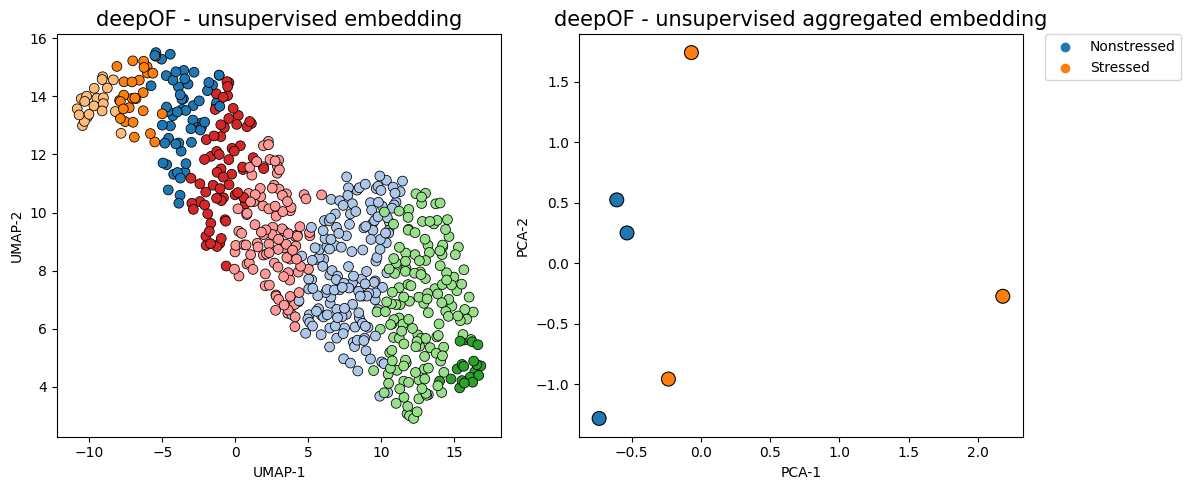

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments=None,
    samples=100,
    colour_by="cluster",
    ax=ax1,
    save=False,  # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments="time on cluster",  # Can also be set to 'mean' and 'median'
    exp_condition="CSDS",
    show_aggregated_density=False,
    ax=ax2,
    save=False,  # Set to True, or give a custom name, to save the plot,
)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.tight_layout()
plt.show()

In [25]:
deepof.visuals.export_annotated_video(
    my_deepof_project,
    soft_counts = soft_counts,
    supervised_annotations = None,
    # Time selection parameters
    #bin_size = "0:0:10",
    #bin_index = "0:1:0",
    precomputed_bins = None,
    frame_limit_per_video = 100,
    # ROI functionality
    #roi_number = 1,
    #animals_in_roi = ["B"],
    #roi_mode = "mousewise",
    #others
    #behaviors = ["Cluster_0", "B_W_nose2nose"],
    experiment_id = None,
    min_confidence = 0.75,
    min_bout_duration = None,
    display_time = True,
    display_counter = True,
    display_arena = True,
    #display_markers = True,
    #display_mouse_labels = True,
    exp_conditions = {},
    cluster_names = None,
)

Exporting behavior videos     : 100%|██████████| 10/10 [00:17<00:00,  1.75s/ video]


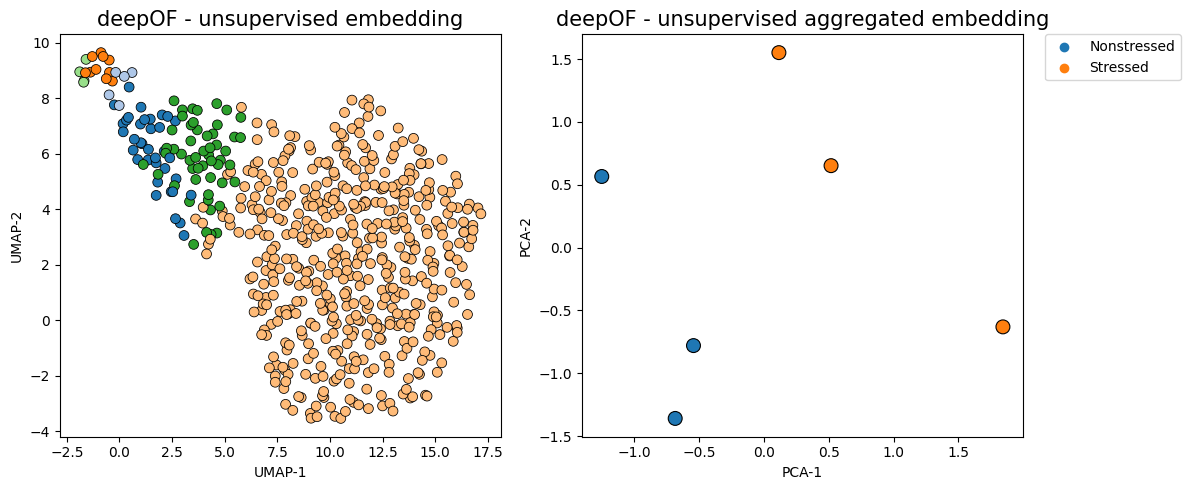

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments=None,
    samples=100,
    colour_by="cluster",
    ax=ax1,
    save=False,  # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments="time on cluster",  # Can also be set to 'mean' and 'median'
    exp_condition="CSDS",
    show_aggregated_density=False,
    ax=ax2,
    save=False,  # Set to True, or give a custom name, to save the plot,
)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.tight_layout()
plt.show()

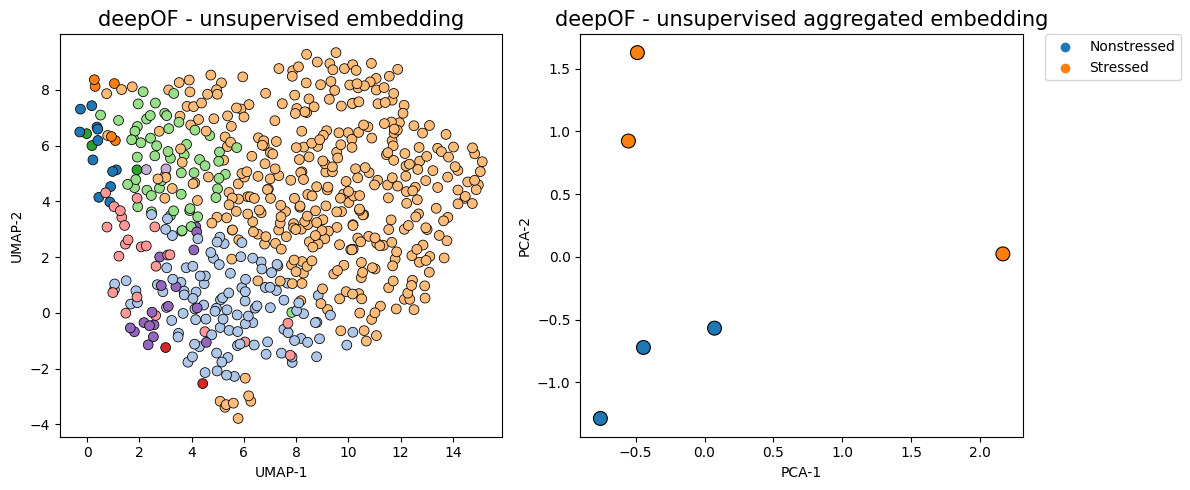

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments=None,
    samples=100,
    colour_by="cluster",
    ax=ax1,
    save=False,  # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments="time on cluster",  # Can also be set to 'mean' and 'median'
    exp_condition="CSDS",
    show_aggregated_density=False,
    ax=ax2,
    save=False,  # Set to True, or give a custom name, to save the plot,
)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.tight_layout()
plt.show()

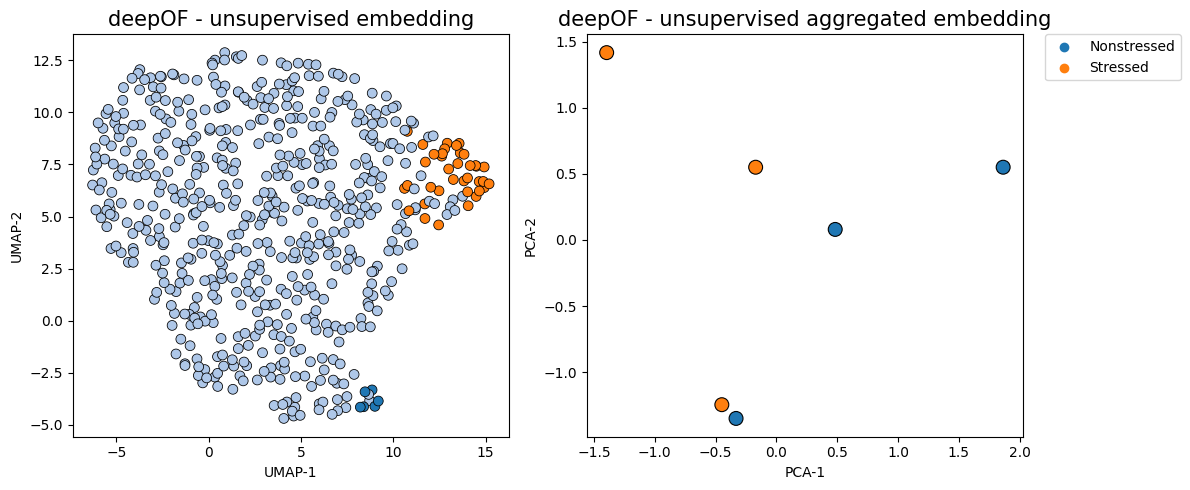

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments=None,
    samples=100,
    colour_by="cluster",
    ax=ax1,
    save=False,  # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments="time on cluster",  # Can also be set to 'mean' and 'median'
    exp_condition="CSDS",
    show_aggregated_density=False,
    ax=ax2,
    save=False,  # Set to True, or give a custom name, to save the plot,
)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.tight_layout()
plt.show()

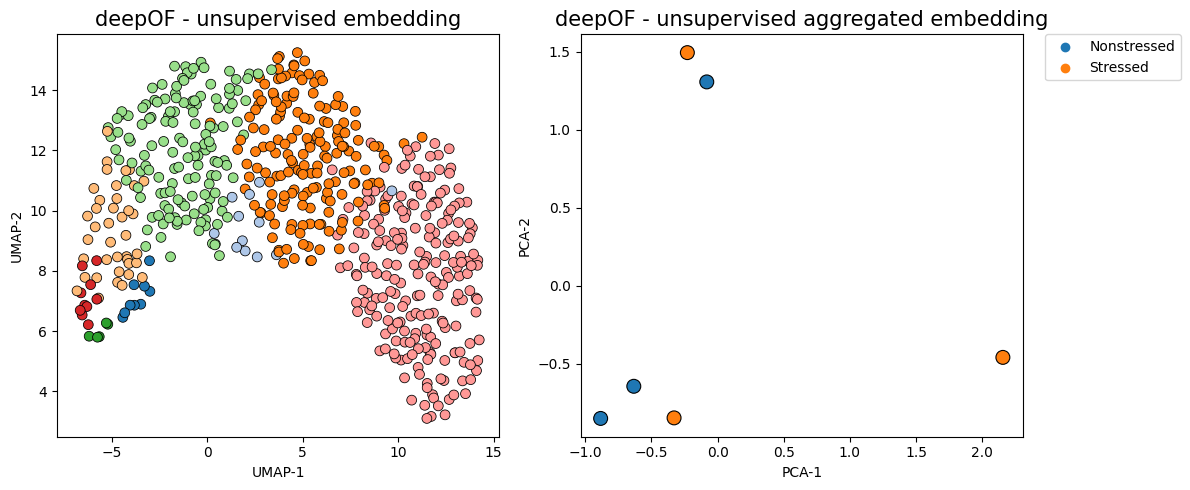

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments=None,
    samples=100,
    colour_by="cluster",
    ax=ax1,
    save=False,  # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments="time on cluster",  # Can also be set to 'mean' and 'median'
    exp_condition="CSDS",
    show_aggregated_density=False,
    ax=ax2,
    save=False,  # Set to True, or give a custom name, to save the plot,
)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.tight_layout()
plt.show()

In [5]:
'''
trained_models = deepof.clustering.model_utils_new.embedding_model_fitting(
    preprocessed_object=preprocessed_object,
    adjacency_matrix=adj_matrix,
    embedding_model="VaDE",
    encoder_type="recurrent",
    batch_size=1024,
    latent_dim=6,
    epochs=10,
    log_history=True,
    log_hparams=False,
    n_components=10,
    kmeans_loss=0.0,
    temperature=0.1,
    contrastive_similarity_function="cosine",
    contrastive_loss_function="nce",
    beta=0.1,
    tau=0.1,
    output_path="",
    data_path=os.path.join(my_deepof_project._project_path, my_deepof_project._project_name, 'Tables'),
    pretrained=False,
    save_checkpoints=False,
    save_weights=True,
    input_type=False,
    bin_info=bin_info,
    run=0,
    kl_annealing_mode="linear",
    kl_warmup=15,
    reg_cat_clusters=0.0,
    recluster=False,
    interaction_regularization=0.0,
)
'''

Epoch 1/10
73/73 [==============================] - 81s 891ms/step - total_loss: 47.8896 - reconstruction_loss: 45.8409 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.0167 - kl_divergence: -5.1844 - kmeans_loss: 1.9032 - number_of_populated_clusters: 9.9958 - confidence_in_selected_cluster: 0.6428
Epoch 2/10
73/73 [==============================] - 80s 1s/step - total_loss: 42.9641 - reconstruction_loss: 41.6749 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.0500 - kl_divergence: -4.4796 - kmeans_loss: 1.7605 - number_of_populated_clusters: 9.9906 - confidence_in_selected_cluster: 0.6392
Epoch 3/10
73/73 [==============================] - 86s 1s/step - total_loss: 42.0796 - reconstruction_loss: 41.1911 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.0833 - kl_divergence: -3.9566 - kmeans_loss: 1.6229 - number_of_populated_clusters: 9.9945 - confidence_in_selected_cluster: 0.6090
Epoch 4/10
73/73 [======================

Computing embeddings          : 100%|██████████| 6/6 [02:05<00:00, 20.95s/table]


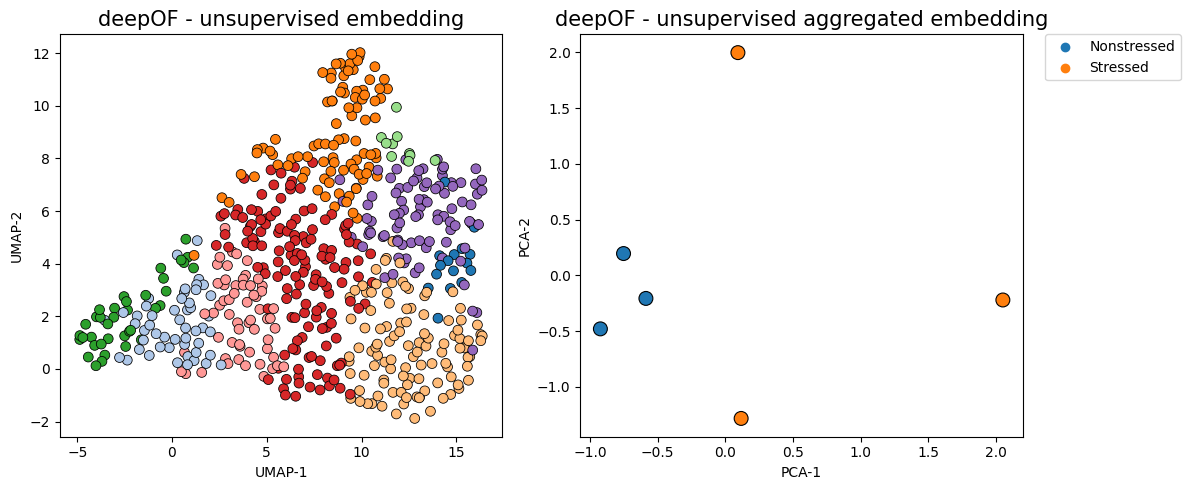

In [6]:
'''


# Get embeddings, soft_counts, and breaks per video
embeddings, soft_counts = deepof.model_utils.embedding_per_video(
    coordinates=my_deepof_project,
    to_preprocess=to_preprocess, 
    model=trained_models,
    animal_id="B",
    global_scaler=global_scaler,
)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments=None,
    samples=100,
    colour_by="cluster",
    ax=ax1,
    save=False,  # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments="time on cluster",  # Can also be set to 'mean' and 'median'
    exp_condition="CSDS",
    show_aggregated_density=False,
    ax=ax2,
    save=False,  # Set to True, or give a custom name, to save the plot,
)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.tight_layout()
plt.show()
'''

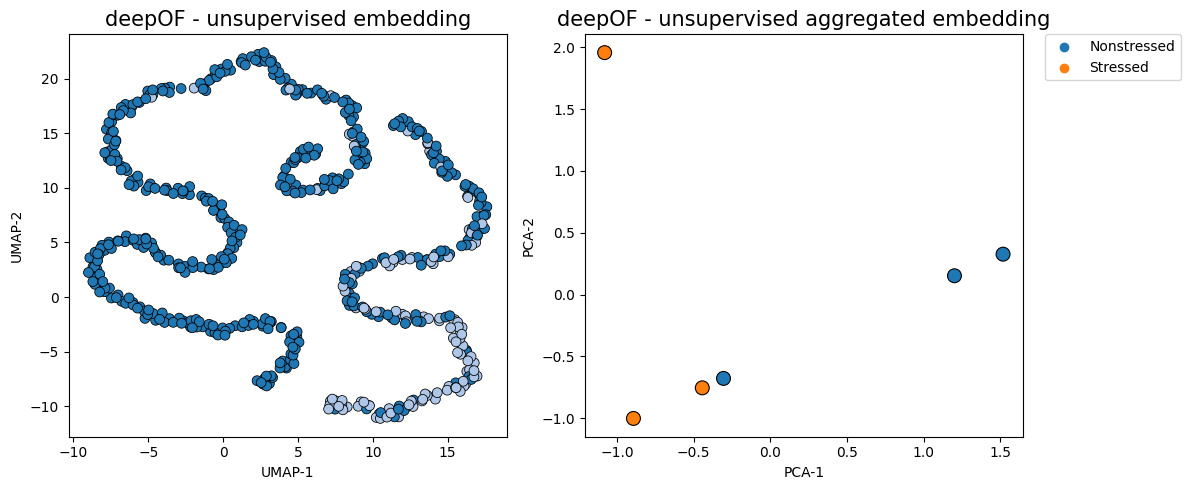

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments=None,
    samples=100,
    colour_by="cluster",
    ax=ax1,
    save=False,  # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments="time on cluster",  # Can also be set to 'mean' and 'median'
    exp_condition="CSDS",
    show_aggregated_density=False,
    ax=ax2,
    save=False,  # Set to True, or give a custom name, to save the plot,
)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.tight_layout()
plt.show()

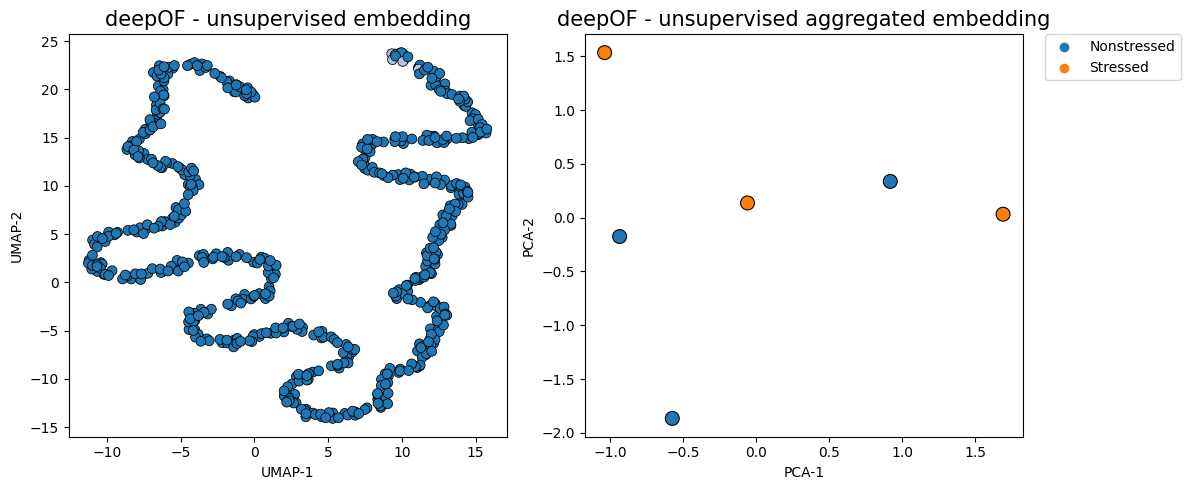

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments=None,
    samples=100,
    colour_by="cluster",
    ax=ax1,
    save=False,  # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments="time on cluster",  # Can also be set to 'mean' and 'median'
    exp_condition="CSDS",
    show_aggregated_density=False,
    ax=ax2,
    save=False,  # Set to True, or give a custom name, to save the plot,
)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.tight_layout()
plt.show()

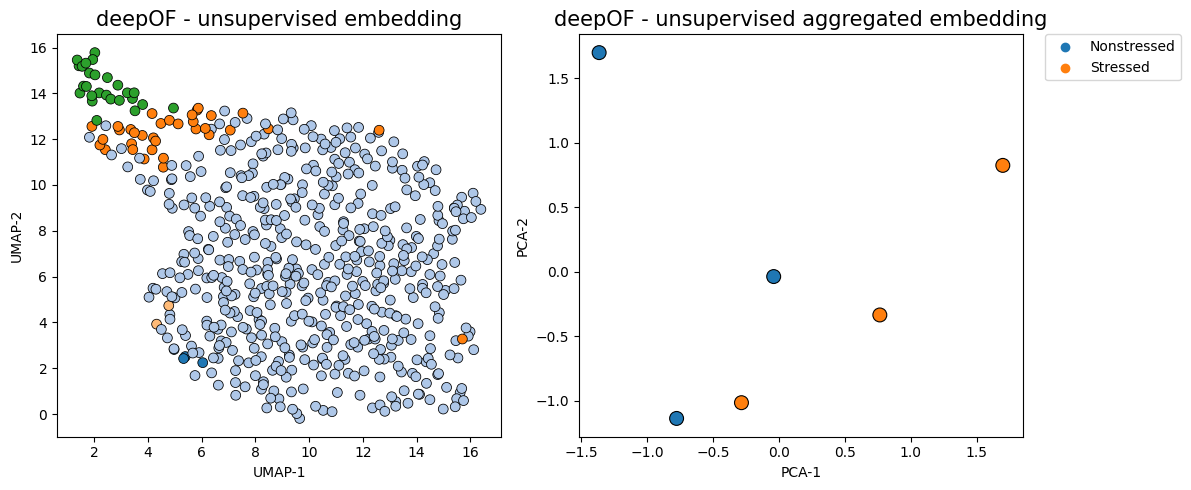

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments=None,
    samples=100,
    colour_by="cluster",
    ax=ax1,
    save=False,  # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments="time on cluster",  # Can also be set to 'mean' and 'median'
    exp_condition="CSDS",
    show_aggregated_density=False,
    ax=ax2,
    save=False,  # Set to True, or give a custom name, to save the plot,
)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.tight_layout()
plt.show()

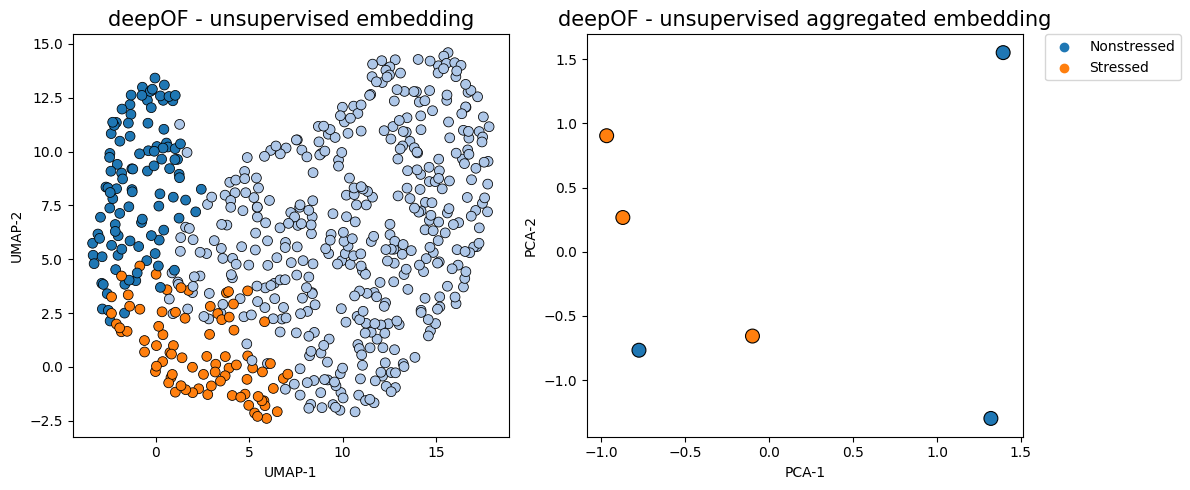

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments=None,
    samples=100,
    colour_by="cluster",
    ax=ax1,
    save=False,  # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments="time on cluster",  # Can also be set to 'mean' and 'median'
    exp_condition="CSDS",
    show_aggregated_density=False,
    ax=ax2,
    save=False,  # Set to True, or give a custom name, to save the plot,
)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.tight_layout()
plt.show()

In [ ]:
soft_counts = deepof.post_hoc.recluster(
    soft_counts=soft_counts, # Previously learned soft counts, used as prior information
    coordinates=my_deepof_project, # Coordinates object
    embeddings=embeddings, # Previously learned unsupervised embeddings to cluster
    min_confidence=0.75, # Minimum confidence to count soft_counts as prior information
    states=10, # Number of states to cluster. If used for cluster selection, set to 'aic'
    min_states=2, # Minimum number of states to cluster for cluster selection
    max_states=25, # Maximum number of states to cluster for cluster selection
)

KeyboardInterrupt: 

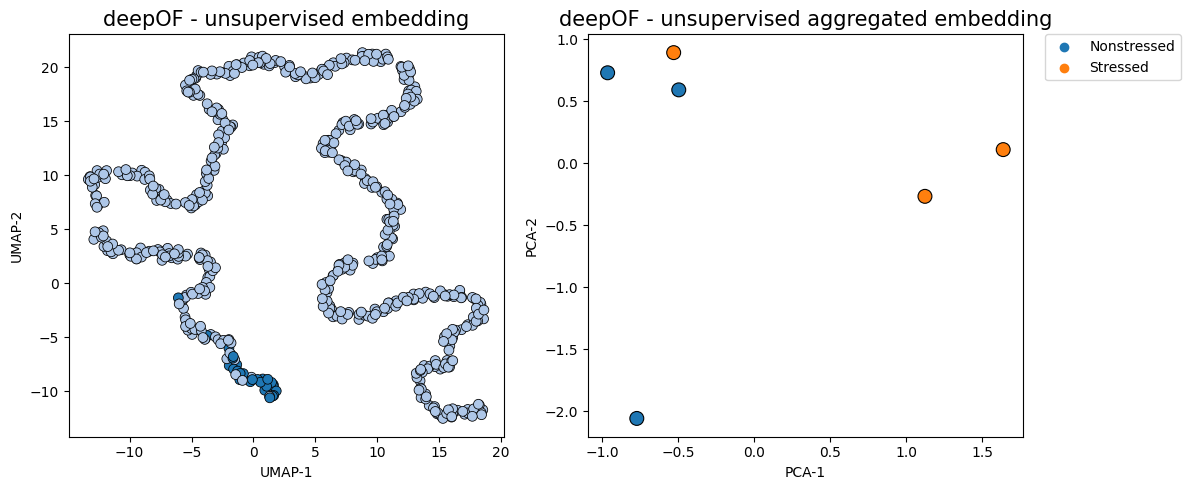

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments=None,
    samples=100,
    colour_by="cluster",
    ax=ax1,
    save=False,  # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments="time on cluster",  # Can also be set to 'mean' and 'median'
    exp_condition="CSDS",
    show_aggregated_density=False,
    ax=ax2,
    save=False,  # Set to True, or give a custom name, to save the plot,
)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.tight_layout()
plt.show()

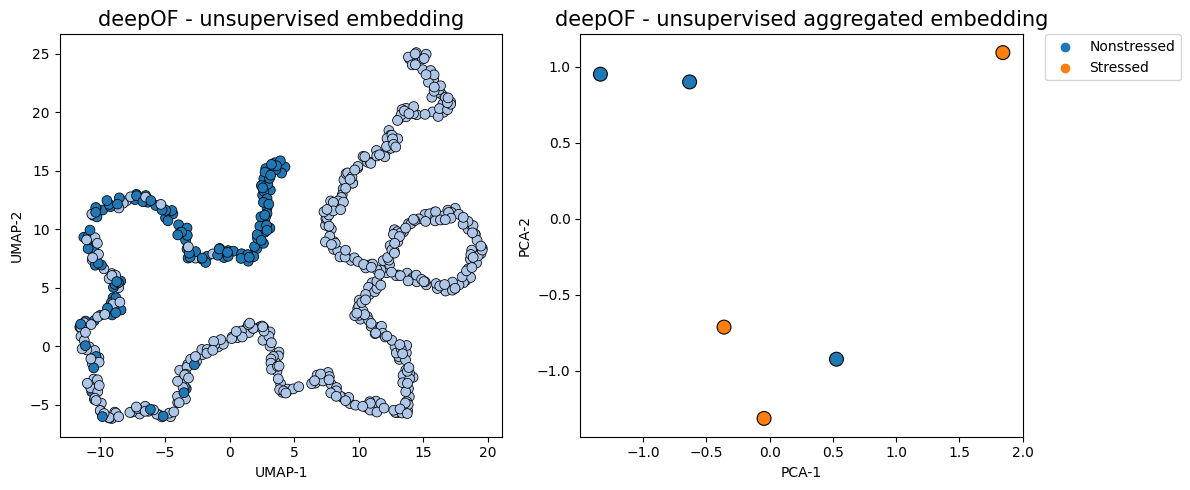

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments=None,
    samples=100,
    colour_by="cluster",
    ax=ax1,
    save=False,  # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments="time on cluster",  # Can also be set to 'mean' and 'median'
    exp_condition="CSDS",
    show_aggregated_density=False,
    ax=ax2,
    save=False,  # Set to True, or give a custom name, to save the plot,
)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.tight_layout()
plt.show()

5.0852705e-25